### Importing Libraries

In [2]:
from datetime import date
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


c:\Users\Rohit\anaconda3\envs\devenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Reading smoke impacts and fire_data from Part 2

In [3]:
with open("./cleaned_data/gj_data_within_650_miles.json", "r") as file:
    fire_data = json.load(file)
for item in fire_data:
    item["fire_start_date"] = date.fromisoformat(item["fire_start_date"])

with open("./cleaned_data/mean_smoke_impact_estimate_for_year.json", "r") as file:
    mean_smoke_impact_estimate_for_year = json.load(file)
mean_smoke_impact_df = pd.DataFrame(list(mean_smoke_impact_estimate_for_year.items()), columns=['Year', 'Value'])
mean_smoke_impact_df["Year"] = mean_smoke_impact_df["Year"].astype(int)
mean_smoke_impact_last_20_years = mean_smoke_impact_df[mean_smoke_impact_df["Year"]>2000]

mean_smoke_impact_forcecast = pd.read_csv("./cleaned_data/future_smoke_estimate.csv")

### Reading Consumer Purchase Index (CPI) data for St. Petersburg for inflation correction

In [4]:
cpi_data = pd.read_csv("./cleaned_data/CPI St. Petersburg.csv")

### Reading Airport Passengers data

In [5]:
airport_passenger_data = pd.read_csv("./cleaned_data/St. Pete Airport Passengers.csv")
airport_passenger_data.columns = airport_passenger_data.columns.str.strip()

In [11]:
airport_passenger_data["Total_Passengers"] = airport_passenger_data[["May", "June", "July", "August", "September", "October"]].sum(axis=1)

### Data Cleaning for Tourism Development Tax/Bed Tax

Note: Considering only the months in the fire season: May - Oct for each year

In [6]:
tourism_tax_year = defaultdict(list)
for year in range(2001,2022):
    excel_file_path = f"./raw_data/extension_data/TourismDevelopmentTax/F3FY{year}.xlsx"
    tourism_tax_raw = pd.read_excel(excel_file_path, sheet_name="Tourist Development Tax")
    july_to_oct_prv_year = list(tourism_tax_raw[tourism_tax_raw.iloc[:, 0].str.contains("Pinellas", na=False)].iloc[0, 1:5])
    may_june_tax_curr_year = list(tourism_tax_raw[tourism_tax_raw.iloc[:, 0].str.contains("Pinellas", na=False)].iloc[0, 11:13])

    tourism_tax_year[year-1].extend(july_to_oct_prv_year)
    tourism_tax_year[year].extend(may_june_tax_curr_year)

# remove over and underflow years
del tourism_tax_year[2000]
del tourism_tax_year[2021]
    

In [7]:
total_tourism_tax_year = pd.DataFrame({
    "Year": tourism_tax_year.keys(),
    "Value": [sum(taxes) for taxes in tourism_tax_year.values()]
})


#### Correcting the total taxes for inflation to 2023 USD

In [8]:
cpi_2023 = cpi_data[cpi_data["Date"] == 2023]["CPI St. Petersburg"].values[0]
total_tourism_tax_year["Adjusted_Value (millions)"] = total_tourism_tax_year.apply(
    lambda row: (row["Value"] * (cpi_2023 / cpi_data[cpi_data["Date"] == row["Year"]]["CPI St. Petersburg"].values[0]))/10**6,
    axis=1
)

### Analysis relation between Bed Tax and Airport footfall

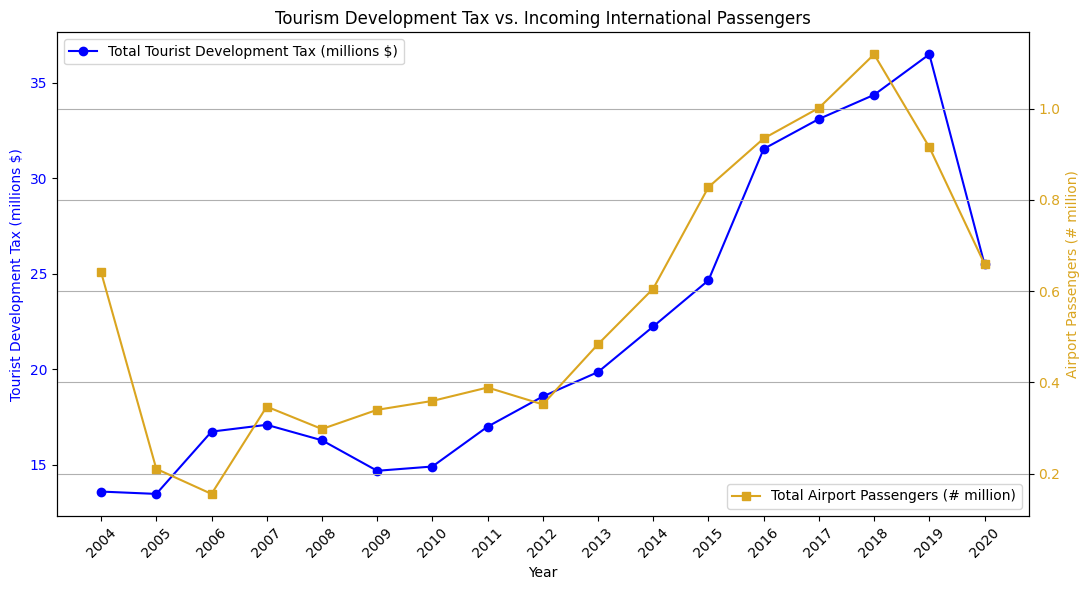

In [12]:
# Create a year range for the data
year_range_comparison = [year for year in range(2004, 2021)]

# Create the figure and the left y-axis
fig, ax_left = plt.subplots(figsize=(11, 6))

# Plot Tourist Tax on the left y-axis
ax_left.plot(year_range_comparison, 
             total_tourism_tax_year[total_tourism_tax_year["Year"].isin(year_range_comparison)]["Adjusted_Value (millions)"], 
             label='Total Tourist Development Tax (millions $)',
             marker='o',
             color="blue")
ax_left.set_ylabel("Tourist Development Tax (millions $)", color="blue")
ax_left.tick_params(axis='y', labelcolor="blue")

# Configure x-axis
ax_left.set_xticks(year_range_comparison)
ax_left.set_xticklabels(year_range_comparison, rotation=45)

# Create the right y-axis
ax_right = ax_left.twinx()

# Plot Airport Passengers on the right y-axis
ax_right.plot(year_range_comparison, 
              airport_passenger_data[airport_passenger_data["Year"].isin(year_range_comparison)]["Total_Passengers"]/10**6, 
              label='Total Airport Passengers (# million)',
              marker='s',
              color="goldenrod")
ax_right.set_ylabel("Airport Passengers (# million)", color="goldenrod")
ax_right.tick_params(axis='y', labelcolor="goldenrod")

# Add legends
ax_left.legend(loc='upper left')  # Legend for the left y-axis
ax_right.legend(loc='lower right')  # Legend for the right y-axis

# Add title, grid, and adjust layout
ax_left.set_xlabel("Year")
plt.title(f"Tourism Development Tax vs. Incoming International Passengers")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
year_range_airport =  [year for year in range(2004,2021)]
print("Correlation between Tourism development tax and Airport Passengers count")
pearsonr(total_tourism_tax_year[total_tourism_tax_year["Year"].isin(year_range_airport)]["Adjusted_Value (millions)"], 
                   airport_passenger_data[airport_passenger_data["Year"].isin(year_range_airport)]["Total_Passengers"])[0]

Correlation between Tourism development tax and Airport Passengers count


0.8964744800841804

### Analyzing smoke impact on Tourism Tax Collection

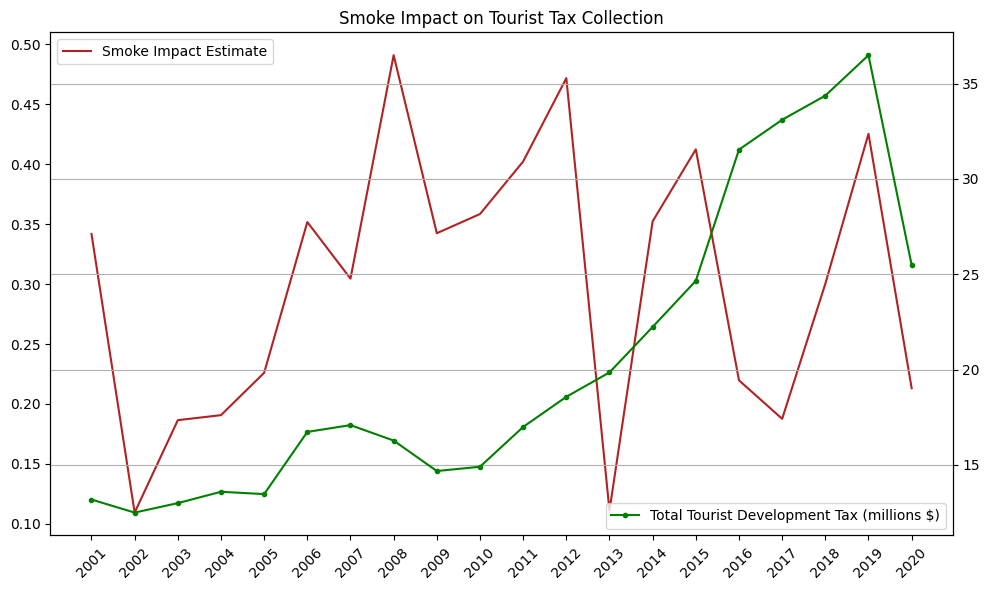

In [525]:
year_range_tax =  [int(year) for year in list(mean_smoke_impact_last_20_years["Year"])]

fig, ax_left = plt.subplots(figsize=(10, 6))
ax_left.plot(year_range_tax, 
         mean_smoke_impact_last_20_years["Value"], 
         label='Smoke Impact Estimate',
         color= "firebrick")

ax_left.set_xticks(year_range_tax)
ax_left.set_xticklabels(year_range_tax, rotation=45)

ax_right = ax_left.twinx()
ax_right.plot(year_range_tax, 
         total_tourism_tax_year["Adjusted_Value (millions)"], 
         label='Total Tourist Development Tax (millions $)',
         marker='.',
         color="green")

ax_left.legend(loc='upper left')  # Legend for the left y-axis
ax_right.legend(loc='lower right')  # Legend for the right y-axis
plt.title(f"Smoke Impact on Tourist Tax Collection")
plt.grid(True)
plt.tight_layout()
plt.show()

In [175]:
corr, _ = pearsonr(mean_smoke_impact_last_20_years["Value"], total_tourism_tax_year["Adjusted_Value (millions)"])

In [262]:
corr

0.05996533468686718

## Smoke estimate impact on Airport Passengers

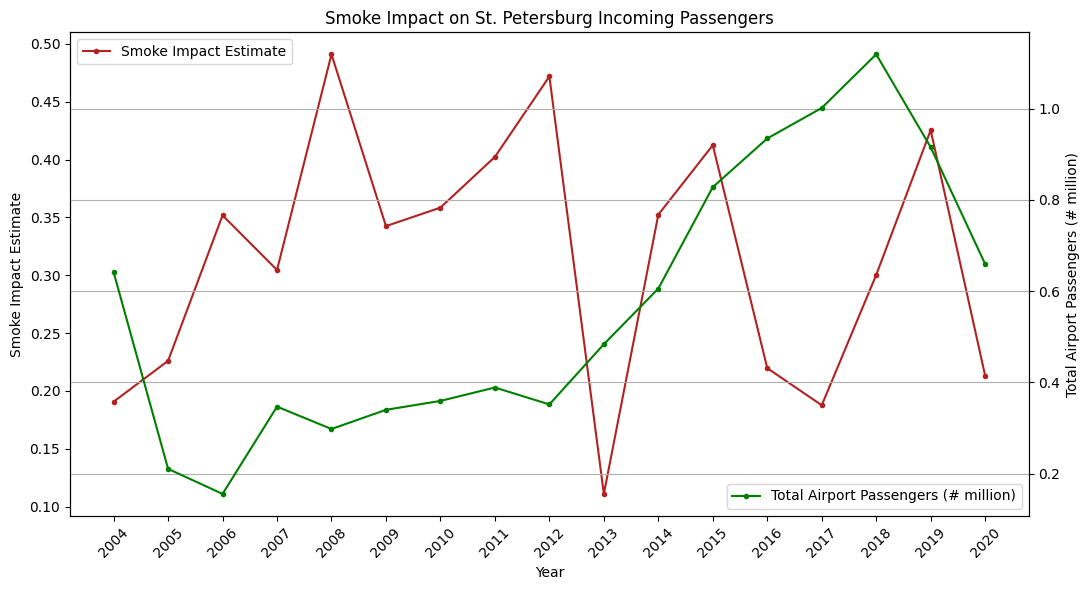

In [ ]:


fig, ax_left = plt.subplots(figsize=(11, 6))
ax_left.plot(year_range_airport, 
         mean_smoke_impact_last_20_years[mean_smoke_impact_last_20_years["Year"].isin(year_range_airport)]["Value"], 
         label='Smoke Impact Estimate',
         marker='.',
         color= "firebrick")
ax_left.set_ylabel("Smoke Impact Estimate")

ax_left.set_xticks(year_range_airport)
ax_left.set_xticklabels(year_range_airport, rotation=45)

ax_right = ax_left.twinx()
ax_right.plot(year_range_airport, 
         airport_passenger_data[airport_passenger_data["Year"].isin(year_range_airport)]["Total_Passengers"]/10**6, 
         label='Total Airport Passengers (# million)',
         marker='.',
         color="green")
ax_right.set_ylabel("Total Airport Passengers (# million)")

ax_left.legend(loc='upper left')  # Legend for the left y-axis
ax_right.legend(loc='lower right')  # Legend for the right y-axis
ax_left.set_xlabel("Year")
plt.title(f"Smoke Impact on St. Petersburg Incoming Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()

In [392]:
### correlation between smoke impact and total passenger volume at St. Petersburg airport
pearsonr(mean_smoke_impact_last_20_years[mean_smoke_impact_last_20_years["Year"].isin(year_range_airport)]["Value"], 
                   airport_passenger_data[airport_passenger_data["Year"].isin(year_range_airport)]["Total_Passengers"])[0]

-0.24457574506799823

## Art, culture, heritage and recreation revenue impact
Note: These are already inflation corrected to 2023 $

In [381]:
gdp_raw = pd.read_csv("./raw_data/extension_data/CAGDP2_FL_2001_2021.csv")
gdp_raw.columns = gdp_raw.columns.str.strip()
gdp_raw["Description"] = gdp_raw["Description"].str.strip()

gdp_achr = gdp_raw[(gdp_raw["GeoName"] == "Pinellas, FL") & 
                    (gdp_raw["Description"] == "Arts, entertainment, recreation, accommodation, and food services")]

In [382]:
gdp_achr_values = gdp_achr.melt(
    id_vars=["GeoFIPS", "GeoName", "Region", "TableName", "LineCode", "IndustryClassification", "Description", "Unit"],
    var_name="Year",
    value_name="Value"
)[["Year", "Value"]]


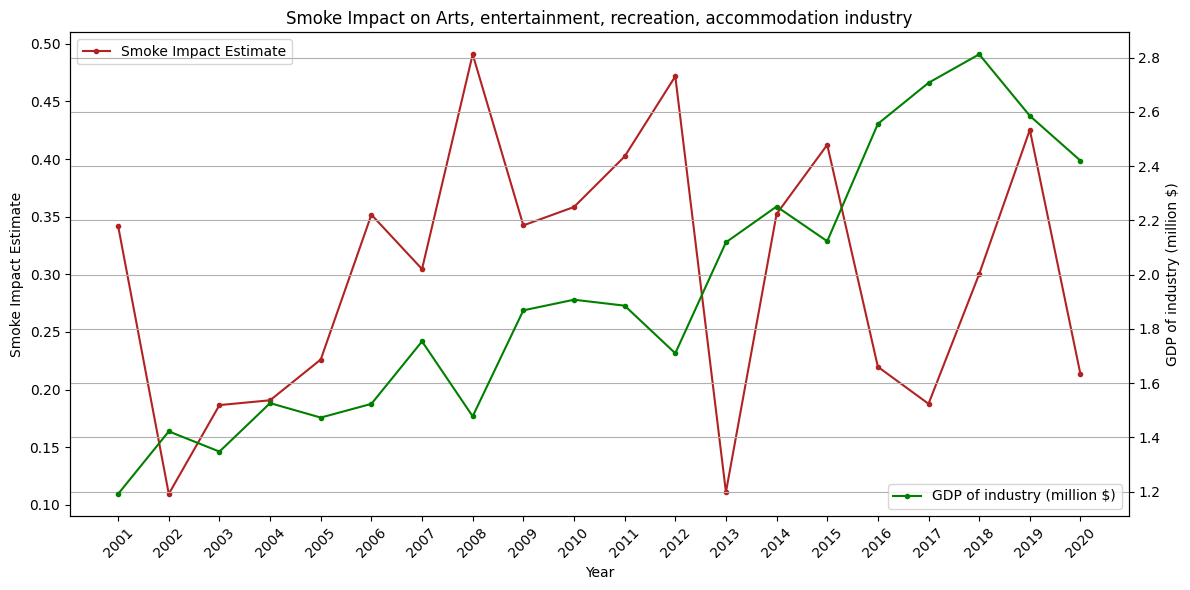

In [409]:
fig, ax_left = plt.subplots(figsize=(12, 6))
ax_left.plot(year_range_tax, 
         mean_smoke_impact_last_20_years[mean_smoke_impact_last_20_years["Year"].isin(year_range_tax)]["Value"], 
         label='Smoke Impact Estimate',
         marker=".",
         color= "firebrick")
ax_left.set_ylabel("Smoke Impact Estimate")

ax_left.set_xticks(year_range_tax)
ax_left.set_xticklabels(year_range_tax, rotation=45)

ax_right = ax_left.twinx()
ax_right.plot(year_range_tax, 
         gdp_achr_values[gdp_achr_values["Year"].astype("int").isin(year_range_tax)]["Value"].astype("int")/10**6, 
         label='GDP of industry (million $)',
         marker=".",
         color="green")
ax_right.set_ylabel("GDP of industry (million $)")

ax_left.legend(loc='upper left', ncol=1)  # Legend for the left y-axis
ax_right.legend(loc='lower right', ncol=1)  # Legend for the right y-axis
ax_left.set_xlabel("Year")
plt.title(f"Smoke Impact on Arts, entertainment, recreation, accommodation industry")
plt.grid(True)
plt.tight_layout()
plt.show()

In [384]:
### correlation between smoke impact and art, recreation gdp
pearsonr(mean_smoke_impact_last_20_years[mean_smoke_impact_last_20_years["Year"].isin(year_range_tax)]["Value"], 
                   gdp_achr_values[gdp_achr_values["Year"].astype("int").isin(year_range_tax)]["Value"].astype("int"))[0]

-0.03713698691773657

## SBA Loan Data Analysis

In [ ]:
excel_file_path = "./raw_data/extension_data/sba loan data/sba_disaster_loan_data_fy01.xlsx"
sba_loan_raw = tourism_tax_raw = pd.read_excel(excel_file_path, sheet_name="")

In [413]:
coverage_ratio_percent = defaultdict(float)
coverage_ratio_percent_avg = defaultdict(float)
for year in range(2000,2023):
    excel_file_path = f"./raw_data/extension_data/sba loan data/sba_disaster_loan_data_fy{str(year)[-2:]}.xlsx"
    sheet_name = f"FY{str(year)[-2:]} Business"
    sba_loan_raw = pd.read_excel(excel_file_path, sheet_name=sheet_name)

    sba_loan_raw.columns = sba_loan_raw.iloc[3,:] # columns names start from 4th row
    sba_loan_filtered = sba_loan_raw[(sba_loan_raw["Damaged Property State Code"] == "FL" ) & 
                                     (sba_loan_raw["FEMA Disaster Number"].notna()) &
                                     (pd.to_numeric(sba_loan_raw["Total Verified Loss"], errors='coerce') > 0)] \
                                    [["Total Verified Loss", "Total Approved Loan Amount"]]
    total_loss = sba_loan_filtered["Total Verified Loss"].sum()
    total_loan_approved = sba_loan_filtered["Total Approved Loan Amount"].sum()
    if total_loss == 0.0:
        continue
    if total_loan_approved >= total_loss:
        coverage_ratio_percent[year] = 100.0
    else:
        coverage_ratio_percent[year] = (total_loan_approved/total_loss)*100




In [320]:
coverage_ratio_percent_df = pd.DataFrame({
    "Year": coverage_ratio_percent.keys(),
    "Value": coverage_ratio_percent.values()
})

In [482]:
#checking stationary nature using ADF test, H0 : Series is non-stationary

adf_result = adfuller(coverage_ratio_percent_df["Value"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -2.043650678759216
p-value: 0.26776763962920014
The series is non-stationary (fail to reject null hypothesis).


In [487]:
# Convert data to Prophet's required format
df_prophet = coverage_ratio_percent_df.copy() 
df_prophet = df_prophet.rename(columns={'Year': 'ds', 'Value': 'y'})
# Fit Prophet model
model_prophet = Prophet(changepoint_prior_scale=0.5)
model_prophet.fit(df_prophet)

# Make future predictions
future = model_prophet.make_future_dataframe(periods=100, freq="A")  # Forecast 30 periods ahead
forecast = model_prophet.predict(future)
forecast["year"] = forecast["ds"].dt.year
forecast = forecast[["year", "yhat", "yhat_lower", "yhat_upper"]]
forecast_future = forecast[(forecast["year"]>=2023) & (forecast["year"]<=2030)]

18:18:51 - cmdstanpy - INFO - Chain [1] start processing
18:18:51 - cmdstanpy - INFO - Chain [1] done processing


In [498]:
coverage_ratio_with_forecast_df = pd.concat([coverage_ratio_percent_df, forecast_future[["year", "yhat"]].rename(columns = {"year":"Year", "yhat":"Value"})])

In [502]:
slope, intercept, _, _, _ = linregress(coverage_ratio_with_forecast_df["Year"], coverage_ratio_with_forecast_df["Value"])
y_fit = slope * coverage_ratio_with_forecast_df["Year"] + intercept

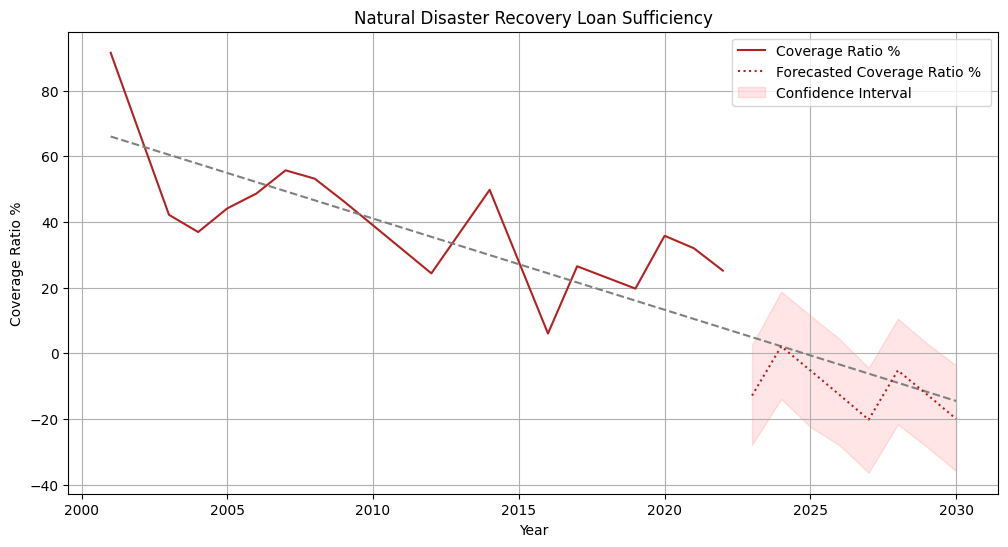

In [521]:
plt.figure(figsize=(12, 6))
plt.plot(coverage_ratio_percent_df["Year"], coverage_ratio_percent_df["Value"], label='Coverage Ratio %', color='firebrick')
plt.plot(coverage_ratio_with_forecast_df["Year"], y_fit, color='grey', linestyle='--')
plt.plot(forecast_future["year"], forecast_future["yhat"], label='Forecasted Coverage Ratio % ', color='firebrick', linestyle=':')
plt.fill_between(forecast_future["year"],forecast_future['yhat_lower'],forecast_future['yhat_upper'],color='red', alpha=0.1, label='Confidence Interval')
plt.title('Natural Disaster Recovery Loan Sufficiency')
plt.xlabel('Year')
plt.ylabel('Coverage Ratio %')
plt.legend()
plt.grid(True)
plt.show()